In [1]:
import os
from glob import glob
import numpy as np
import h5py
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from sklearn.model_selection import KFold
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut
import decoder.manifold as mf
from decoder.metrics import get_error

In [31]:
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}
p = 0
exps = ['Enriched','Dissimilar','Similar']
datapath = alldata[exps[p]][2]
day = 1  # Recording days, None for all days
min_rate = 0/60  # Minimum transient rate for active cells
ybin = 80  # Number of spatial bins
ysigma = 2  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

## Load data

In [32]:
data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate, verbose=True)

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent
    
print('Recording days:', days)
print('Context fam/nov:', ctx)

------------------------------------
Total cells: 91
Active cells: 90
Proportion of active cells 98.90 %
Active in both 97.80 %
Active exclusively in Fam 1.10 %
Active exclusively in Nov 0.00 %
------------------------------------
Recording days: [1 1 1 1]
Context fam/nov: [0 1 0 1]


## Prepare data (spatial tuning)

In [33]:
tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=True)

In [34]:
def collect_data(tuning, ctx=np.array([0,1,0,1]), ybin=80):
    
    y_edges = np.linspace(0,4,ybin+1)  # Unify position data to (0,4)
    y_centers = (y_edges[:-1] + y_edges[1:])/2
    Fdata, ydata  = [], []
    for c in range(len(set(ctx))):
        F = np.concatenate([tuning[k] for k in np.where(ctx==c)[0]], axis=2)  # (ncell, ybin, ntrial)
        Fdata.append(np.transpose(F, (2,1,0)))  # (ntrial, ybin, ncell)
        ydata.append(np.tile(y_centers, (F.shape[2],1)))  # (ntrial, ybin)
        
    return Fdata, ydata

Fdata, ydata = collect_data(tuning, ctx=ctx, ybin=ybin)

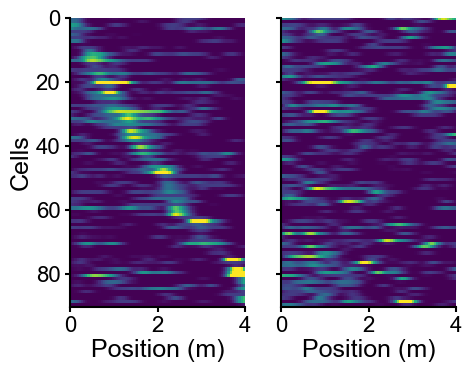

In [35]:
def display_tuning(Fdata, sort=0):
    
    tuning_mean = [F.mean(axis=0).T for F in Fdata]
    ncell = tuning_mean[0].shape[0]
    order = ut.sort_tuning(tuning_mean[sort])[1]
    vmax = np.percentile(np.hstack([M.ravel() for M in tuning_mean]), 99.5)
    
    fig, axs = plt.subplots(1,len(Fdata),figsize=(5,4),sharey=True)
    for c, M in enumerate(tuning_mean):
        axs[c].imshow(M[order], interpolation='none', vmin=0, vmax=vmax, extent=[0,4,ncell,0])
        axs[c].set_aspect('auto')
        axs[c].set_xlabel('Position (m)')
    axs[0].set_ylabel('Cells')
    fig.tight_layout()
    
display_tuning(Fdata, sort=0)

In [7]:
print(Fdata[0].shape)

(20, 80, 90)


## Useful functions

In [36]:
def prepare_data(Fs, ys, trial=None, average=False):
    '''
    Parameters
    ----------
    Fs : numpy array (ntrial, ybin, ncell)
        Spatial tuning of a given mouse with all trials stacked along axis=0
    ys : numpy array (ntrial, ybin)
        Position vector of each trial
    trial : numpy 1d array
        Indices of selected trials
    average : bool
        Whether to average over trials

    Returns
    -------
    X : array (n_samples, ncell)
    y : array (n_samples,)
        where n_samples = ybin if trial-averaged, otherwise n_samples = ntrial*ybin
    '''
    if trial is None:  # Take all trials
        trial = np.arange(Fs.shape[0])
    elif isinstance(trial, int):
        trial = [trial]
    if average:
        X = np.mean(Fs[trial,:,:], axis=0)  # (ybin, ncell)
        y = np.mean(ys[trial,:], axis=0)  # (ybin,)
    else:
        X = np.vstack([Fs[r,:,:] for r in trial])
        y = np.hstack([ys[r,:] for r in trial])
    ## Discard points where all cells are silent
    silent = (X.sum(axis=1) == 0)
    if np.any(silent):
        X = X[~silent,:]
        y = y[~silent]
        
    return X, y

def shuffle_trial(Fs, seed=0):
    '''For each cell, shuffle the trial ID while keeping the spatial tuning.
    '''
    rng = np.random.default_rng(seed)
    Fshuffled = Fs.copy()  # (ntrial, ybin, ncell)
    for i in range(Fs.shape[2]):
        Fshuffled[:,:,i] = rng.permutation(Fs[:,:,i])  # Shuffle by rows (trials)
        
    return Fshuffled

def decode_novel_cv(Fdata, ydata, nfold=10, shuffle=0, y2cm=100, align=True, **kwargs):
    
    X_train_fam, y_train_fam = prepare_data(Fdata[0], ydata[0], trial=None, average=True)  # Familiar context (train)    
    
    ntrial, ybin, ncell = Fdata[1].shape  # Novel context
    if shuffle:
        cv = KFold(n_splits=nfold, shuffle=True, random_state=shuffle)
    else:
        cv = KFold(n_splits=nfold, shuffle=False)
    error = []
    
    for train_set, test_set in cv.split(np.zeros((ntrial,1))): 
        
        X_train_nov, y_train_nov = prepare_data(Fdata[1], ydata[1], trial=train_set, average=True)  # Novel context (train)
        X_test_nov, y_test_nov = prepare_data(Fdata[1], ydata[1], trial=test_set, average=False)  # Novel context (test)
    
        spd = mf.SpatialNovelDecoder2(**kwargs)
        spd.fit([X_train_fam, X_train_nov], y_train_fam)
        y_pred = spd.predict(X_test_nov, align=align)
    
        ind = np.isfinite(y_pred)
        if not np.all(ind):
            print('Warning: neglect %d NaN in test data (%.4g%% samples)' % (np.sum(~ind), 100*np.mean(~ind)))
        error.append(y2cm*get_error(y_test_nov[ind], y_pred[ind], kind='median'))
    
    return np.array(error)

## Decode novel position with manifolds alignment

Aligned disparity: 0.3769


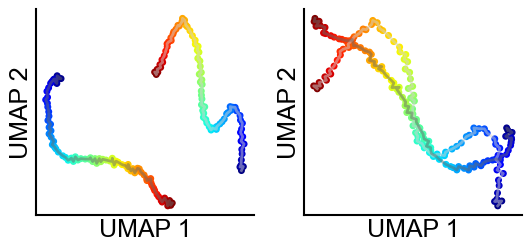

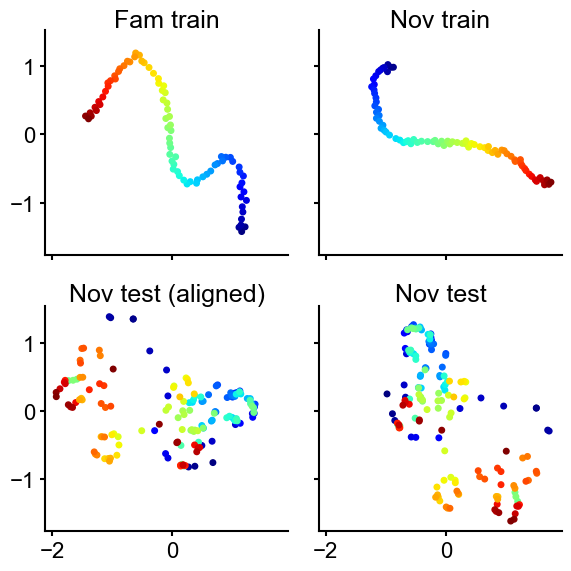

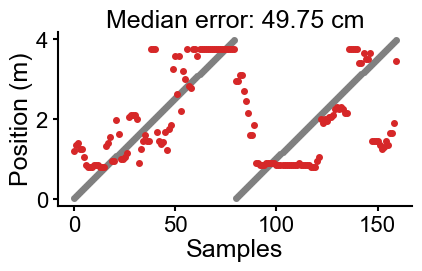

In [50]:
def decode_novel_test(Fdata, ydata, y2cm=100, test_set=[0], align=True, **kwargs):
    
    ntrial, ybin, ncell = Fdata[1].shape  # Novel context
    train_set = np.setdiff1d(np.arange(ntrial), test_set)
    X_train_fam, y_train_fam = prepare_data(Fdata[0], ydata[0], trial=None, average=True)  # Familiar context (train)    
    X_train_nov, y_train_nov = prepare_data(Fdata[1], ydata[1], trial=train_set, average=True)  # Novel context (train)
    X_test_nov, y_test_nov = prepare_data(Fdata[1], ydata[1], trial=test_set, average=False)  # Novel context (test)
    
    spd = mf.SpatialNovelDecoder2(**kwargs)
    spd.fit([X_train_fam, X_train_nov], y_train_fam)
    
    disparity = mf.disparity(spd.X_train_aligned[0], spd.X_train_aligned[1])
    print('Aligned disparity: %.4g' % disparity)
    
    ## Show Fam and Nov manifolds before and after alignment (training data)
    fig, axs = plt.subplots(1,2,figsize=(5.6,2.8))
    axs[0].plot(*spd.X_train_embed[0].T, lw=2, c='lightgray', alpha=0.5)
    axs[0].plot(*spd.X_train_embed[1].T, lw=2, c='dimgray', alpha=0.5)
    axs[0].scatter(*spd.X_train_embed[0].T, c=y_train_fam, cmap='jet', s=16)
    axs[0].scatter(*spd.X_train_embed[1].T, c=y_train_nov, cmap='jet', s=16)
    axs[1].plot(*spd.X_train_aligned[0].T, lw=2, c='lightgray', alpha=0.5)
    axs[1].plot(*spd.X_train_aligned[1].T, lw=2, c='dimgray', alpha=0.5)
    axs[1].scatter(*spd.X_train_aligned[0].T, c=y_train_fam, cmap='jet', s=16)
    axs[1].scatter(*spd.X_train_aligned[1].T, c=y_train_nov, cmap='jet', s=16)
    for ax in axs:
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
    fig.tight_layout()
    fig.savefig('Manifolds alignment.svg')
    
    ## Prediction
    y_pred = spd.predict(X_test_nov, align=align)
    ind = np.isfinite(y_pred)
    if not np.all(ind):
        print('Warning: neglect %d NaN in test data (%.4g%% samples)' % (np.sum(~ind), 100*np.mean(~ind)))
    error = y2cm*get_error(y_test_nov[ind], y_pred[ind], kind='median')
    
    ## Show Nov embedding (testing data) relative to the trained manifolds
    fig, axs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(6,6))
    axs[0,0].set_title('Fam train')
    axs[0,0].scatter(*spd.X_train_norm[0].T, c=y_train_fam, cmap='jet', s=16, rasterized=True)
    axs[0,1].set_title('Nov train')
    axs[0,1].scatter(*spd.X_train_norm[1].T, c=y_train_nov, cmap='jet', s=16, rasterized=True)
    axs[1,1].set_title('Nov test')
    axs[1,1].scatter(*spd.X_test_norm.T, c=y_test_nov, cmap='jet', s=16, rasterized=True)
    axs[1,0].set_title('Nov test (aligned)')
    axs[1,0].scatter(*spd.X_test_aligned.T, c=y_test_nov, cmap='jet', s=16, rasterized=True)
    fig.tight_layout()
    
    ## Show predicted and true position
    fig, ax = plt.subplots(figsize=(4.5,3))
    ax.plot(y_test_nov, ls='none', marker='.', ms=8, c='gray')
    ax.plot(y_pred, ls='none', marker='.', ms=8, c='tab:red')
    ax.set_title('Median error: %.4g cm' % error)
    ax.set(xlabel='Samples', ylabel='Position (m)')
    fig.tight_layout()

params = dict(method='knr', k=10, knr_metric='euclidean', # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian'
              reduction='umap', dim=2,  # 'none'|'pca'|'umap'   
              yrange=(0,4), ybin=ybin,  # Used in landmark calculation
              n_neighbors=8, min_dist=0.6, metric='cosine', random_state=0)  # UMAP parameters 
              
decode_novel_test(Fdata, ydata, y2cm=100, test_set=[8,9], align=True, **params)

## Test decoding parameters

In [21]:
pars = [1,2,3,4,5,6]
errors = [[] for _ in range(len(pars))]

for d, par in enumerate(pars):
    print('Decoding with parameter %g ...' % par)
    params = dict(method='knr', k=10, knr_metric='euclidean', # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian'
                  reduction='umap', dim=par,  # 'none'|'pca'|'umap'   
                  yrange=(0,4), ybin=ybin,  # Used in pvcorr and bayesian
                  n_neighbors=8, min_dist=0.6, metric='cosine', random_state=0)  # UMAP parameters 
    
    errors[d] = decode_novel_cv(Fdata, ydata, nfold=10, shuffle=2, y2cm=100, align=True, **params)

Decoding with parameter 1 ...
Decoding with parameter 2 ...
Decoding with parameter 3 ...
Decoding with parameter 4 ...
Decoding with parameter 5 ...
Decoding with parameter 6 ...


[112.775, 86.075, 71.625, 87.275, 70.35, 62.82499999999999]


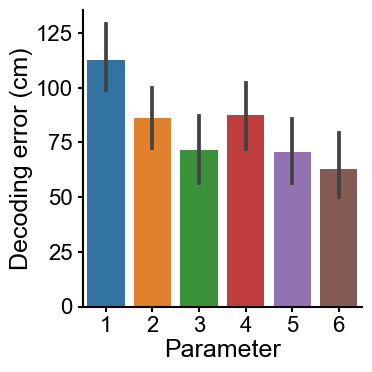

In [22]:
df = pd.DataFrame(np.column_stack(errors), columns=pars)  # (cv, n_pars)
print([np.mean(err) for err in errors])

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(df, ax=ax, errorbar=('ci',95))
ax.set(xlabel='Parameter', ylabel='Decoding error (cm)')
fig.tight_layout()

## Run for all datasets

In [23]:
datapaths = alldata['Enriched'] + alldata['Dissimilar'] + alldata['Similar']
day = 1 
min_rate = 0/60
ybin = 80
ysigma = 2
nfold = 10
shuffle = 2
error_list = []
params = dict(method='knr', k=10, knr_metric='euclidean', # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian'
              reduction='umap', dim=6,  # 'none'|'pca'|'umap'   
              yrange=(0,4), ybin=ybin,  # Used in pvcorr and bayesian
              n_neighbors=8, min_dist=0.6, metric='cosine', random_state=0)  # UMAP parameters

for p, datapath in enumerate(datapaths):
    
    print('Analyzing:', os.path.split(datapath)[1])
    
    data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate)
    with h5py.File(datapath, 'r') as f:
        yrange = f['params/yrange'][()]  # Dataset dependent
        
    tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma, spike=False, transient=True)
    Fdata, ydata = collect_data(tuning, ctx=ctx, ybin=ybin)
    
    errors = np.zeros(2)  # Aligned and none
    errors[0] = np.mean(decode_novel_cv(Fdata, ydata, nfold=nfold, shuffle=shuffle, y2cm=100, align=True, **params))
    errors[1] = np.mean(decode_novel_cv(Fdata, ydata, nfold=nfold, shuffle=shuffle, y2cm=100, align=False, **params))
    
    error_list.append(errors)
    
df = pd.DataFrame(np.vstack(error_list), columns=['Aligned','None'])  # (n_mice,2)
with pd.ExcelWriter('Decode position align.xlsx') as writer:
    df.to_excel(writer, sheet_name='Align', index=False)

Analyzing: Enriched1_6044_invivo.hdf5
Analyzing: Enriched2_6045_invivo.hdf5
Analyzing: Enriched3_6160_invivo.hdf5
Analyzing: Enriched4_6161_invivo.hdf5
Analyzing: Distinct1_111_invivo.hdf5
Analyzing: Distinct2_114_invivo.hdf5
Analyzing: Distinct3_132_invivo.hdf5
Analyzing: Similar1_182_invivo.hdf5
Analyzing: Similar2_1506_invivo.hdf5
Analyzing: Similar3_6815_invivo.hdf5
Analyzing: Similar4_6826_invivo.hdf5
Analyzing: Similar5_937_invivo.hdf5
Analyzing: Similar6_939_invivo.hdf5
Analyzing: Similar7_948_invivo.hdf5
Analyzing: Similar8_5454_invivo.hdf5


## Plot results

In [29]:
def plot_paired_bars(errors, colors):
    
    fsize = plt.rcParams['font.size']
    lwidth = plt.rcParams['axes.linewidth']
    n_mice, nb = errors.shape

    fig, ax = plt.subplots(figsize=(2.4,3.6))

    ## Draw paired lines
    for error in errors:
        ax.plot(range(nb), error, lw=1.2, c='gray', alpha=0.8, zorder=-1)  # marker='o', ms=4, mfc='none'

    ## Draw bar plot
    width = 0.6
    height = np.mean(errors, axis=0)
    yerr = stats.sem(errors, axis=0)
    for x in range(nb):
        ax.bar(x, height[x], yerr=yerr[x], width=width, color='none', linewidth=lwidth, 
               edgecolor=colors[x], ecolor=colors[x], capsize=4,
               error_kw=dict(elinewidth=lwidth, capthick=lwidth))

    df = pd.DataFrame({'Error': errors.ravel(),
                       'Data': np.array(['Aligned','None']*n_mice)})
    pairs = [('Aligned','None')]
    pformat = {'pvalue_thresholds':[[1e-3,'***'],[1e-2,'**'],[0.05,'*'],[1,'ns']], 'fontsize':fsize}
    annot = Annotator(ax, pairs, data=df, x='Data', y='Error')
    annot.configure(test='t-test_paired', loc='outside', line_height=0., line_width=lwidth, pvalue_format=pformat)
    annot.apply_and_annotate()

    ax.set(xlim=[-0.5,1.5], xticks=[0,1])
    ax.set_xticklabels(['Aligned','None'], rotation=30)
    ax.set(ylabel='Decoding error (cm)', yticks=np.arange(0,130,25))
    fig.tight_layout()
    
    return fig, ax

In [25]:
excelfile = r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Decode position align.xlsx'
mice = [0,1,2,3] + [4,5,6]
# mice = [7,8,9,10,11,12,13,14]
# mice = [7,8,12,14]

A = pd.read_excel(excelfile, sheet_name='Align').to_numpy()  # (Mouse,2)
B = A[mice]
print(B)
print(np.mean(B, axis=0))

[[ 71.675 106.45 ]
 [ 76.8   116.3  ]
 [ 62.825 110.15 ]
 [ 84.65  117.2  ]
 [ 81.825 106.   ]
 [ 74.625 122.05 ]
 [ 77.3   117.725]]
[ 75.67142857 113.69642857]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Aligned vs. None: t-test paired samples, P_val:1.940e-05 t=-1.209e+01


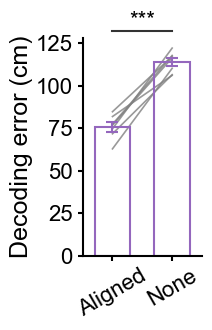

In [30]:
fig, ax = plot_paired_bars(B, ['tab:purple','tab:purple'])
fig.savefig('Decoding novel aligned.svg')